### Домашнее задание по NLP # 2

Составление словарей для классификации по тональности

При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”)). Еще один пример: “теплое пиво” – это плохо, а “теплый свитер” – это хорошо.

Составление таких словарей в ручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora (https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf).

Данные для задания – уже знакомые вам отзывы на банки, собранные с нескольких сайтов Рунета. Отзывы могут быть как положительными (оценка 5), так и отрицательными (оценка 1).  

Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.
Обучите по коллекции предложений word2vec

Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
    тест на определение ближайших слов
    тест на аналогии (мужчина – король : женщина – королева)
    тест на определение лишнего слова.

Постройте несколько визуализаций:
    TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
    задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.  
    
Ссылка на примеры визуализаций: https://towardsdatascience.com/game-of-thrones-word-embeddings-does-r-l-j-part-2-30290b1c0b4b

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from pymystem3 import Mystem
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import json
from tqdm import tqdm
import bz2
from gensim.models import word2vec

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


unable to import 'smart_open.gcs', disabling that module


## Загружаем и готовим данные

In [4]:
# читаем файл json зипованный в формат bz2
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [04:18, 778.34it/s] 


In [5]:
df = pd.DataFrame.from_dict(responses)

In [6]:
df.head()

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.
3,643609,лицензия № 1481,Сбербанк России,г. Ставрополь,2015-06-05 13:51:01,2,NaN,False,Добрый день!! Я открыл расчетный счет в СберБа...,Меняют проценты комиссии не предупредив и не ...
4,anfisa-2003,лицензия № 2766,ОТП Банк,г. Челябинск,2015-06-05 10:58:12,1,NaN,False,"04.03.2015 г. взяла кредит в вашем банке, заяв...",Верните денежные средства за страховку


In [7]:
pymorphy2_analyzer = MorphAnalyzer()
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']

In [8]:
def preproc_review(review):
    tokens = nltk.sent_tokenize(review)
    list_ = []
    for index in range(len(tokens)):
        text = re.sub('[^А-Яа-яё]', ' ', tokens[index])
        text = text.lower()
        text = nltk.word_tokenize(text)
        text = [word for word in text if word not in mystopwords]
        text = [pymorphy2_analyzer.parse(word)[0].normal_form for word in text]
        text = ' '.join(text)
        text = nltk.word_tokenize(text)
        list_.append(text)
    return list_

In [9]:
df_100 = df[['text', 'rating_grade']][:10000]

In [10]:
df_100.head()

,text,rating_grade
0,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [11]:
%%time
df_100['changed'] = df_100.text.apply(preproc_review)

Wall time: 12min 8s


In [12]:
df_100.head()

,text,rating_grade,changed
0,Добрый день! Я не являюсь клиентом банка и пор...,NaN,"[[добрый, день], [являться, клиент, банка, пор..."
1,Доброго дня! Являюсь держателем зарплатной кар...,NaN,"[[добрый, день], [являться, держатель, зарплат..."
2,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,"[[здравствовать], [дублировать, свой, заявлени..."
3,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,"[[добрый, день], [открыть, расчётный, счёт, сб..."
4,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,"[[год, взять, кредит, ваш, банка, заявить, я, ..."


### Записываем данные для последующей подачи в обучение модели

In [13]:
sentences = []  

for review in df_100["changed"]:
    sentences += review

In [14]:
sentences

[['добрый', 'день'],
 ['являться',
  'клиент',
  'банка',
  'поручитель',
  'кредитный',
  'договор',
  'являться',
  'какой',
  'либо',
  'другой',
  'лицо',
  'письменно',
  'оформить',
  'отношение',
  'банк',
  'повод',
  'урегулирование',
  'чей',
  'либо',
  'задолженность'],
 ['начинать',
  'март',
  'год',
  'начать',
  'приходить',
  'бесконечный',
  'письмо',
  'ооо',
  'прить',
  'коллект',
  'адрес',
  'город',
  'москва',
  'уваровский',
  'переулок',
  'дом',
  'квартира',
  'угроза',
  'возбуждение',
  'уголовный',
  'дело',
  'отношение',
  'гражданин',
  'филиппов',
  'эдуард',
  'владимир',
  'который',
  'уклоняться',
  'уплата',
  'взять',
  'кредит',
  'договор',
  'год',
  'договор',
  'год'],
 ['весь',
  'ответственность',
  'хотеть',
  'заверить',
  'вышеуказанный',
  'гражданин',
  'который',
  'разыскивать',
  'знак',
  'мыть',
  'адрес',
  'зарегистрировать'],
 ['какой',
  'образ',
  'удостовериться',
  'подлинность',
  'документ',
  'оформить',
  'имя',
  'к

### Обучаем модель

In [15]:
%%time
model = word2vec.Word2Vec(sentences, workers=4, size=300, min_count=4, window=8, sample=1e-3)

Wall time: 25.7 s


In [16]:
# размер словаря
print(len(model.wv.vocab))

10363


#### Тест на определение ближайших слов 

In [99]:
words = ['сотрудник', 'ипотека', 'депозит']
for word in words:
    print(word, '\n', '________')
    for word, cos in model.most_similar(positive=[word], topn=3):
        print(word, ': ', cos)
    print('\n')

сотрудник 
 ________
работник :  0.8025516271591187
сотрудница :  0.7703161239624023
специалист :  0.6910191774368286


ипотека 
 ________
автокредит :  0.9120293855667114
автомобиль :  0.7536404132843018
кредит :  0.7468957304954529


депозит 
 ________
вклад :  0.8821640014648438
новогодний :  0.7594566345214844
валютный :  0.7201477289199829




#### Тест на аналогии

In [102]:
model.most_similar(positive=['кредит','ипотека'], negative=['вклад'], topn=1)

[('автокредит', 0.7719825506210327)]

#### Тест на определение лишнего слова

In [94]:
model.doesnt_match(['работник', 'сотрудник', 'стажер', 'кредит'])

'кредит'

In [93]:
model.doesnt_match(['кредит', 'ипотека', 'автокредит', 'депозит'])

'депозит'

### Визуализация

In [17]:
X = model[model.wv.vocab]

In [19]:
from sklearn.decomposition import PCA

In [23]:
pca = PCA(n_components=2)
result = pca.fit_transform(X)

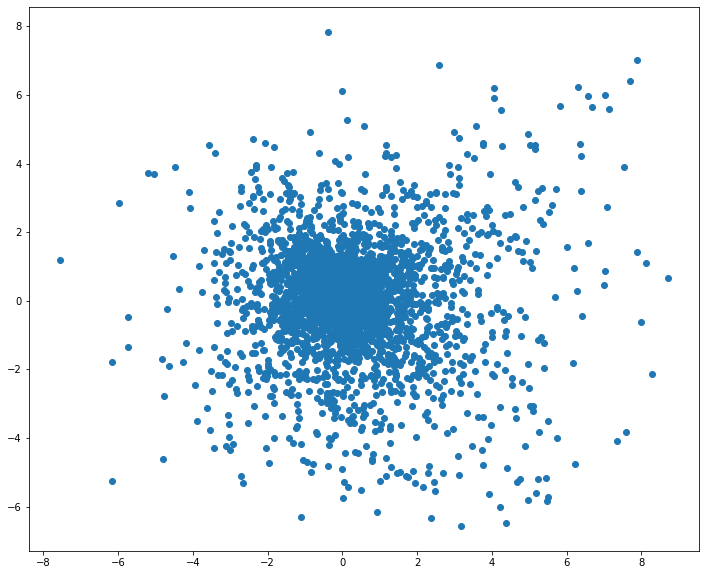

In [51]:
plt.figure(figsize=(12,10))
plt.scatter(result[:, 0], result[:, 1])

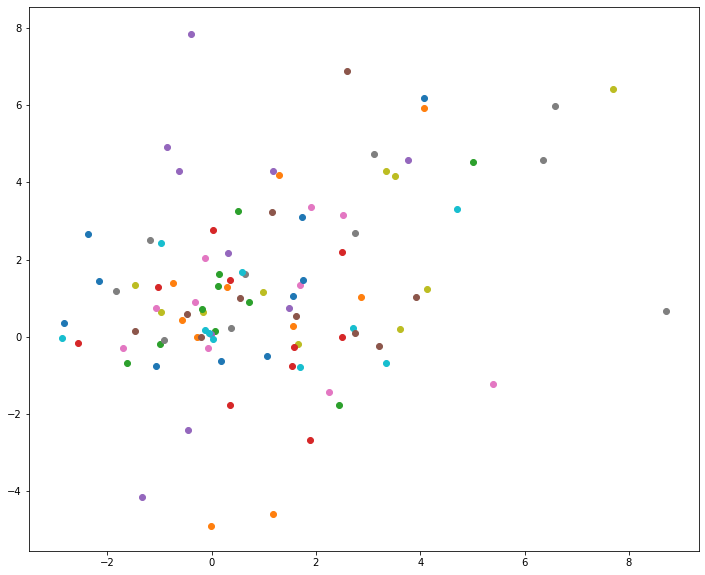

In [50]:
plt.figure(figsize=(12,10))
words = list(model.wv.vocab)[:100]
for i, word in enumerate(words):
    plt.scatter(result[i, 0], result[i, 1])

In [59]:
from nltk import FreqDist
from tqdm import tqdm_notebook as tqdm
from sklearn.manifold import TSNE

top_words = []


fd = FreqDist()
for s in tqdm(sentences):
    fd.update(s)

for w in fd.most_common(100):
    top_words.append(w[0])
    
print(top_words[:50:])
top_words_vec = model[top_words]


['банка', 'карта', 'банк', 'год', 'мой', 'день', 'кредит', 'деньга', 'сотрудник', 'который', 'клиент', 'счёт', 'сумма', 'отделение', 'рубль', 'дать', 'свой', 'заявление', 'сказать', 'вклад', 'договор', 'вопрос', 'номер', 'кредитный', 'ваш', 'время', 'мочь', 'средство', 'платёж', 'телефон', 'такой', 'ответ', 'получить', 'звонок', 'один', 'сбербанк', 'звонить', 'офис', 'месяц', 'проблема', 'весь', 'ситуация', 'услуга', 'быть', 'написать', 'очень', 'какой', 'информация', 'позвонить', 'смс']


In [60]:
%%time
tsne = TSNE(n_components=2, random_state=77)
top_words_tsne = tsne.fit_transform(top_words_vec)

Wall time: 1.28 s


In [62]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE (model, top100 words)")

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Loading BokehJS ...

Text(0.5, 0, 'Скорость')

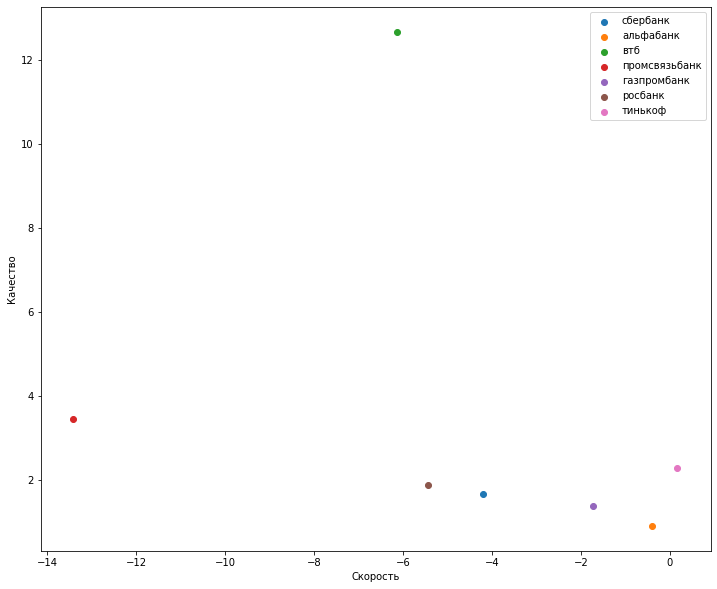

In [91]:
plt.figure(figsize=(12,10))
banks = ['сбербанк', 'альфабанк', 'втб', 'промсвязьбанк', 'газпромбанк', 'росбанк', 'тинькоф']
for bank in banks:
    x = (model['быстро'] - model['медленно']) @ model[bank]
    y = (model['хороший'] - model['плохой']) @ model[bank]
    plt.scatter(x, y, label=bank)
    plt.legend()
plt.ylabel('Качество')
plt.xlabel('Скорость')
